In [2]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib.patches as patches
import seaborn as sb
import r_model
%matplotlib inline

# GP Model-based Collision Avoidance

## 1) Overview 

Here we present a simple application for our proposed methodology for safe policy search based on Gaussian process modelling of the system's dynamics. The implementation is in Python, while the original source code for PILCO is in Matlab. Implementing the algorithm from scratch allowed for (even asked for) some experimentation with different design choices and some of insights drawn are presented here as well.



## 2) Problem description

In this scenario two cars are approaching a junction. We are assuming the point of view of one of the two drivers with the objective of crossing the junction safely by accelerating or braking. 

The system's state space $ \mathcal{X} $ is 4 dimensional (2 position and 2 velocity variables). 
$$ x_t = [x_{1t}, ... , x_{4t} ] $$

The input $u$ has one dimension, proportional to the force applied to the first car.

### 2.1 Safe and unsafe states

In this application the differentiation between safe and unsafe states is intuitive and straightforward. In order to not collide, the cars must not be at the junction (set to be the origin (0,0)) at any one point in time. This can be set as constraint of the form: 
$$ |x_{1t} | > a \quad  \mathbf{OR}  \quad | x_{3t} | > a $$

for the two cars positions. 

So if we denote the set of safe states as 
$$ S = \{x \in X : \ |x_1| > a \  \mathbf{OR} \ |x_3| > a  \}$$ and the unsafe states as $U = X \setminus S $.
If we plot the unsafe part of the state, with the positions of the cars in the two axis and ignoring velocities, we get a rectangle around the origin.









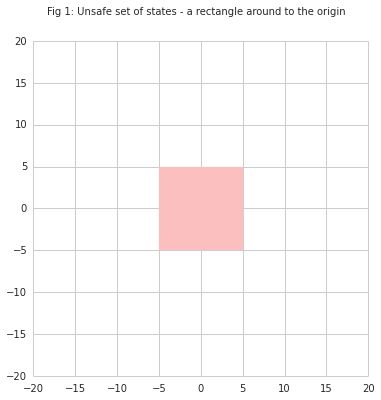

In [3]:
#Plotting the rectangular border between S and U
sb.set_style('whitegrid')
fig1 = pl.figure(figsize=(6,6))
ax1 = fig1.add_subplot(111, aspect='equal')
ax1.add_patch(
    patches.Rectangle((-5, -5),   # (x,y)
                       10,# width
                       10, color=(0.99,0.75,0.75) ))
pl.ylim([-20,20])
pl.xlim([-20,20])
fig1.suptitle("Fig 1: Unsafe set of states - a rectangle around to the origin")
pl.show()




### 2.2 Linear Dynamical System

We are using a very simple linear dynamical system in discreet time, along with some white noise, as the real transition function of the system. However, this information is not available to the algorithm and the LDS is treated as a black box. Non-linearities could be incorporated and we would expect insignificant differences in the algorithm's performance. It should be noted that the system is considered __fully observable__, in the sense that the real states are available, without measurement noise.

$$ x_{t+1} = \pmb{A} x_{t} + \pmb{B} u_{t} + \epsilon_{t}$$
$$ \epsilon \sim \mathcal{N}(0,\sigma) $$

### 2.3 Policy

We assume there is a parametrization of the candidate policies and we need to specify one that completes the task while keeping the system in safe parts of the state space. A policy $\pi^\theta$, where $\theta$ denotes the parameters, allows us to calculate each input $u_{t}$ from each state $x_{t}$, as in:
$$u_{t} = \pi^\theta(x_{t})$$

For now, the policy is a simple linear controller, with 4 gains corresponding to the 4 state dimensions. The end goal is to tune this parameters to values that allow the first car to cross the junction safely (we might need to switch to a more complex and flexible controller later). For this report, the objective is to showcase the way probabilistic trajectories are constructed and the policy evaluation problem: given the values of the parameters $\theta$ we want to estimate the probability of the system passing through the set of unsafe states $U$.  



## 3) Gaussian Process model for the system's dynamics

### 3.1 Formulation

While the system dynamics are in this particular case linear, we don't make use of this fact in the modelling process, to preserve the general applicability of the method. The problem is formulated then as follows: there is an unknown transition function $f$ so that
$$ x_{t+1} = f(x_{t},u_{t})$$

The target variables for our GP to learn are the differences between consecutive states:
$$ \Delta x_{t} = x_{t} - x_{t-1}  $$

Every time step lasts 2 seconds in the current implementation.

Now, treating this as a regression problem, the input space is 5-dimensional (4 for the state and 1 for the input) and the output is 4-dimensional (only the state is predicted).

We use 4 independent GPs for the 4 output dimensions. 

Each one of them uses a squared exponential kernel, with automatic relevance determination (ARD), which means that different lengthscales are used for each (input) dimension. 

In total the hyperparameters of the GP model are 28: 4 signal variances, 4 noise variances and 20 lengthscale parameters.

$$ k(x_{1},x_{2}) = \sigma_{s}^2 \ exp(-\frac{1}{2}(x-m)^T \mathbf{\Lambda}^{-1} (x-m)) + \delta_{x1,x2}\ \sigma_{n}^2$$

### 3.2 Data and training 

The 4 GPs are trained on data obtained by randomly choosing values for $\theta$ and observing the behaviour of the system. 

Every episode consists of 10 steps, for a total duration of 20s. When a model is constructed for the first time, we initialise it by picking a number of episodes to start with, and creating the test data that are used to evaluate the model. Test data consist of 10 episodes.
Having the kernel and the training data, we can tune the hyperparameters of the models. The hyperparameters are tuned by maximising the log likelihood using the L-BFGS optimiser for 20 optimisation steps.

When we get more data, we concatenate the new training data with the previously available, but keep the same testing data for more straightforward comparisons.

To avoid confusion, we are following the convention:
- *Training inputs* (tr_X in the source code) are the $(x_{t},u_{t})$ tuples, given to the GP models as inputs during training, not to be confused with the input to the system $u_{t}$.
- *Training targets* (tr_Y) are the $Dx_{t}$ we train the models on predicting. By *training data* we refer to both training inputs and targets.
- *Test inputs* and *test targets* (te_X and te_Y) that together make the *test data* refer to the corresponding quantities we test on.


### 3.3 The model in action 

Let's get more practical and see what the models can do. We start by observing 10 episodes (~100 training points), and creating the model.

Keep in mind, at the end of this part we want to be able, for a given starting state, and for given values of the parameters $\theta$, to predict the trajectory of the system for a whole episode, with a realistic measure of the uncertainty of this prediction.

In [4]:
D = r_model.GP_model(eps=10,seed=10)

The first thing we will do, to make sure that our GPs can indeed make reasonable predictions is a to perform a *step-by-step* prediction. As one would do in a classic GP regression problem, we give each of the 4 GP the testing points (a 90x5 array, 4 states and 1 input) and the GP presents the corresponding $\Delta x $ (a 90x4 array). 

This is not a realistic situation for our application, since we wouldn't have the whole sequence of states that comprise an episode, but __only__ the first one.

In Figure 2 we plot the step-by-step prediction for the change in the  first car's position.


 /System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/matplotlib/collections.py:548: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


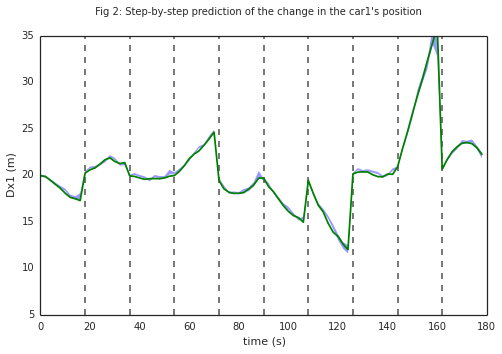

In [5]:
sb.set_style('white')

f2 = pl.figure(figsize=(8,5))
pl.fill_between(range(0,180,2),
        D.step_pred_m[0,0:90],
        D.step_pred_m[0,0:90]+2 * D.step_pred_v[0,0:90]**(0.5),
        D.step_pred_m[0,0:90]-2 * D.step_pred_v[0,0:90]**(0.5),
        linewidth = 0, alpha = 0.4, color='blue')
pl.plot(range(0,180,2),D.te_Y[0:90,0], color='green')
pl.ylim([5,35])
pl.vlines(range(18,180,18),5,35,linestyle='dashed', color=(0.4,0.4,0.4))
pl.xlabel('time (s)')
pl.ylabel('Dx1 (m)')
f2.suptitle(" Fig 2: Step-by-step prediction of the change in the car1's position")
pl.show(f2)


Next we will take on the more difficult task of cascading predictions. The procedure is as follows:

For each episode, we have the starting state (which in this implementation is the same) and the parameters $\theta$ (here randomly generated 4-tuples of the linear controller gains).

Using $\theta$ and $x_{0}$ we calculate $u_{0}$. The first prediction for each episode, $\Delta x_{0}$, is done in the same way as before, from the 5-tuple, of state and input, to the 4-tuple of the differences between current and next states.

For the second prediction and onwards, we want to use the previous outputs of the GP models as inputs for the next step. We get the predicted mean of the state at t=1 simply by 
$$\mu_{x_1} = \mu_{\Delta x_{0}} + x_{0} $$

The variance is the variance of the $\Delta x_{0}$.

The input has to be calculated based on the on prediction of the state as in:
$$ \mu_{u_{1}} = K \mu_{x_{1}}$$
$$ \sigma_{u_{1}}^2 = K^2 \sigma_{x_{1}}^2$$

Now we have the 5 dimensional input for the GPs, along with the corresponding variance of each component. As we know this calculation is in general intractable, and here, following PILCO, we approximate it by calculating the firs two moments and assuming the distribution to be Gaussian, an approach known as *moment matching*.

Given the new prediction, $\Delta x_{2}$ we repeat this procedure to the end of the episode, with one difference; the variance of $x_{t}$ is not simply equal to the variance of $\Delta x_{t-1}$ but is calculated from:

$$\Sigma_{x_t} = \Sigma_{x_{t-1}} + \Sigma_{\Delta x_{t}} + cov[x_{t-1}, \Delta x_{t}] + cov[\Delta x_{t}, x_{t-1}]$$

where the covariance $cov[x_{t-1}, \Delta x_{t}]$ depends on specific parameters of the GP models, and the structure of the policy.

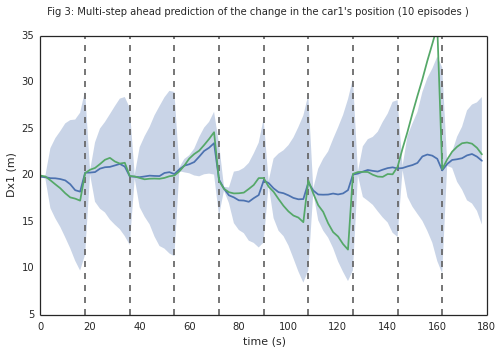

In [6]:
s_pos = 2 * D.S[:,0,0]**0.5

f3 = pl.figure(figsize=(8,5))
pl.fill_between(range(0,180,2),
        D.mus[1:91,0]+s_pos[0:90],
        D.mus[1:91,0]-s_pos[0:90],linewidth = 0, alpha = 0.3)
pl.plot(range(0,180,2),D.mus[1:91,0])
pl.plot(range(0,180,2),D.te_Y[0:90,0])
pl.vlines(range(18,180,18),5,35,linestyle='dashed', color=(0.4,0.4,0.4))
pl.xlabel('time (s)')
pl.ylabel('Dx1 (m)')
f3.suptitle(" Fig 3: Multi-step ahead prediction of the change in the car1's position (10 \
            training episodes )")
pl.ylim([5,35])
pl.show(f3)

Now if we are not satisfied with the resulting predictions, we can get more data and reasonably expect better results. Here we ask for 10 more episodes to be observed, and we use the run() method of the model to update our GPs and predictions.

In [7]:
D.get_more_data(10)
D.run()

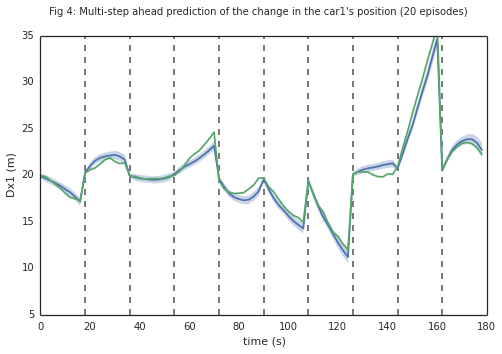

In [8]:
s_pos = 2 * D.S[:,0,0]**0.5

f4 = pl.figure(figsize=(8,5))
pl.fill_between(range(0,180,2),
        D.mus[1:91,0]+s_pos[1:91],
        D.mus[1:91,0]-s_pos[1:91],linewidth = 0, alpha = 0.3)
pl.plot(range(0,180,2),D.mus[1:91,0])
pl.plot(range(0,180,2),D.te_Y[0:90,0])
pl.vlines(range(18,180,18),5,35,linestyle='dashed', color=(0.4,0.4,0.4))
pl.xlabel('time (s)')
pl.ylabel('Dx1 (m)')
f4.suptitle(" Fig 4: Multi-step ahead prediction of the change in the car1's position (20 episodes)")
pl.ylim([5,35])
pl.show(f4)

In [9]:
D.get_more_data(10)
D.run()

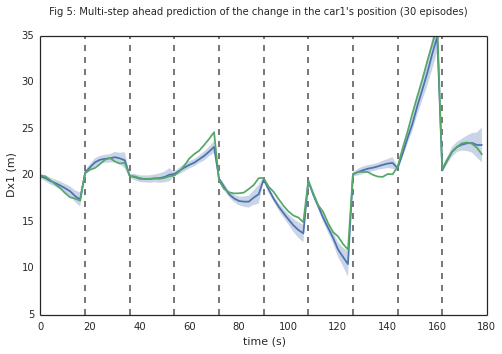

In [10]:
s_pos = 2 * D.S[:,0,0]**0.5

f5 = pl.figure(figsize=(8,5))
pl.fill_between(range(0,180,2),
        D.mus[1:91,0]+s_pos[1:91],
        D.mus[1:91,0]-s_pos[1:91],linewidth = 0, alpha = 0.3)
pl.plot(range(0,180,2),D.mus[1:91,0])
pl.plot(range(0,180,2),D.te_Y[0:90,0])
pl.vlines(range(18,180,18),5,35,linestyle='dashed', color=(0.4,0.4,0.4))
pl.xlabel('time (s)')
pl.ylabel('Dx1 (m)')
f5.suptitle(" Fig 5: Multi-step ahead prediction of the change in the car1's position \
            (30 episodes training)")
pl.ylim([5,35])
pl.show(f5)

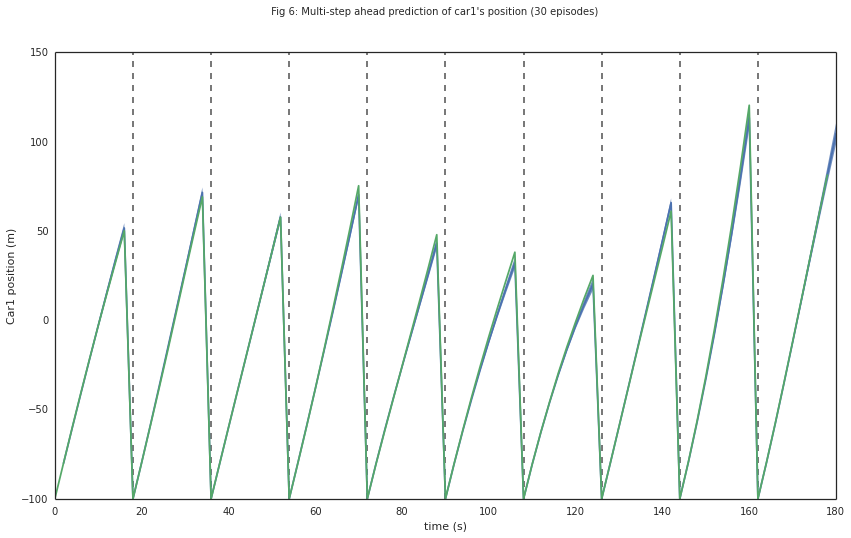

In [11]:
s_pos = 2 * D.state_v[:,0,0]**(0.5)

f6 = pl.figure(figsize=(14,8))
pl.fill_between(range(2,182,2),
        D.state_m[1:91,0]+s_pos[1:91],
        D.state_m[1:91,0]-s_pos[1:91],linewidth = 0, alpha = 0.8)
pl.plot(range(2,182,2),D.state_m[1:91,0])
pl.plot(range(0,180,2),D.te_X[0:90,0])
pl.vlines(range(18,180,18),-100,200,linestyle='dashed', color=(0.4,0.4,0.4))
pl.xlabel('time (s)')
pl.ylabel('Car1 position (m)')
pl.ylim(-100,150)
f6.suptitle(" Fig 6: Multi-step ahead prediction of car1's position (30 episodes)")
pl.show(f6)

## 4) Policy evaluation

Now that we are able to construct a probabilistic prediction of the system's trajectory from a starting policy and parametrization of the policy, we would like to calculate the provability of the system violating the constraints we have imposed. Namely we want to calculate the probability of any of the state predictions $ x_{i} \in \{x_{1}, ..., x_{T}\}$ to belong in the set of unsafe states $U$ (the square around the origin).

### 4.1 2-d visualization of trajectories

Since the unsafe states $U$ are invariant in the 2 of the 4 state space dimensions, we can plot trajectories in a similar style to Fig 1. Let's try that, using the trajectories created in the previous section.


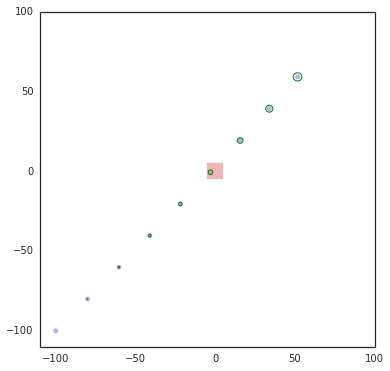

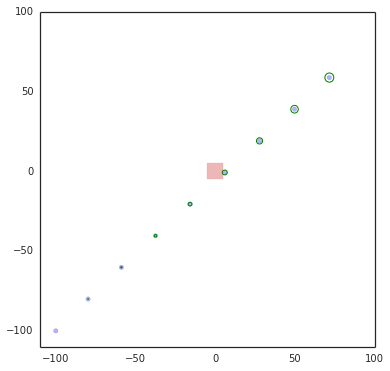

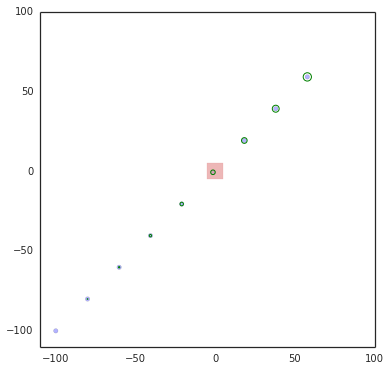

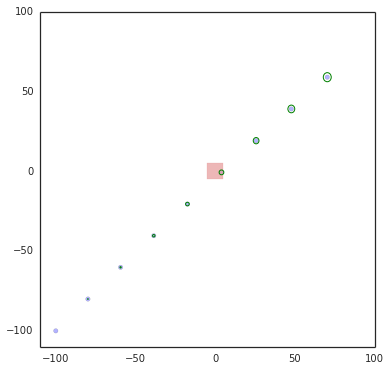

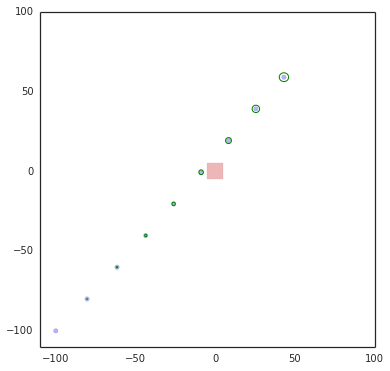

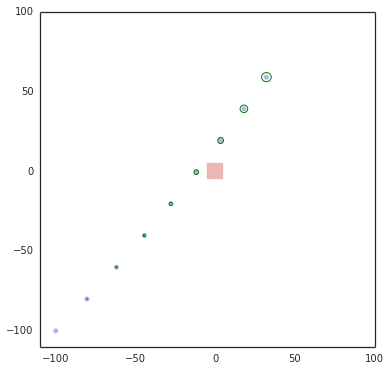

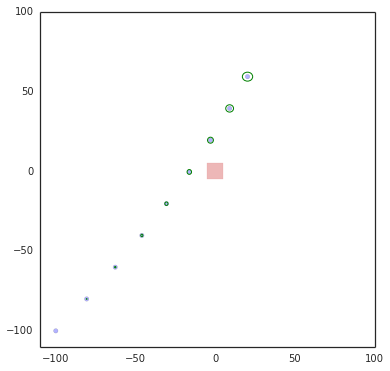

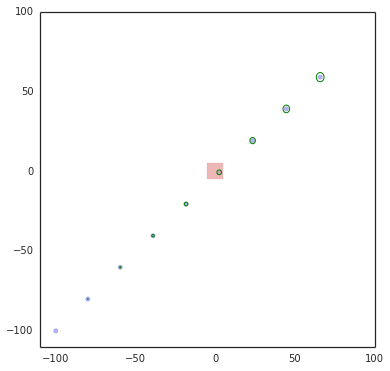

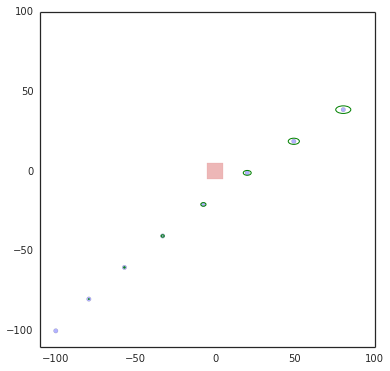

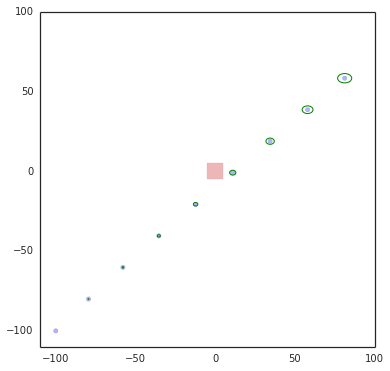

In [12]:
from matplotlib.patches import Ellipse
for k in range(10):
    fig1 = pl.figure(figsize=(6,6))
    ax1 = fig1.add_subplot(111, aspect='equal')
    ax1.add_patch(
        patches.Rectangle((-5, -5),   # (x,y)
                           10,# width
                           10, color=(0.9,0.6,0.6), alpha=0.7 ))
    pl.ylim([-110,100])
    pl.xlim([-110,100])
    for i in range(9):
        pt = (D.state_m[9*k+i,0], D.state_m[9*k+i,2])
        pl.scatter(pt[0],pt[1],alpha=0.3)
        e = Ellipse(xy=pt, width= 4*D.state_v[9*k+i,0,0]**0.5, 
                    height=4*D.state_v[9*k+i,2,2]**0.5, 
                    fill=False, color='green', alpha=1, linewidth=1)
        ax1.add_artist(e)
    

Let's discuss shortly the results in these plots. 

Firstly, it is obvious that the time interval between predictions is not that short and decreasing it arbitrarily is not easy. Usually, in GP regression, obtaining predictions is cheap, especially compared to the cost of training the model. During training, the Kernel matrix has to be inverted, leading to a complexity of $\mathcal{O}(N^3)$, where N are the training data. This has to be repeated for all the output (state space, in this case 4) dimensions $D$, leading to a complexity of $\mathcal{O}(N^3D)$. When the inputs to the GP regression are uncertain, there is a term needed with a complexity of $\mathcal{O}(N^2D^2F)$, where $F$ are the GP input dimensions (in our case), and this calculation has to be repeated for every prediction. For a number of predictions comparable to the number of data, this can be the most computationally intense step.

Secondly, it looks likes the different controller parameters tested didn't have very drastic effects. We could experiment with greater controller gains. Still $\theta$ takes random values, and the controller is probably too simple to take care of the task, so the observed behaviour is bound to be fairly restricted.

### 4.2 Calculating probability of a single point being in $U$

Any point in the probabilistic trajectories constructed is predicted as  4 dimensional Gaussian distribution, 
$x_{t} \sim \mathcal{N}(\mu_{t},\Sigma_{t}) $.  Since we are interested only in the two position variables, we can keep a two dimensional distribution.

#### Conservative covariance approximation
The problem of calculating Gaussian cumulative probabilities over arbitrary shaped spaces is more challenging than one might think. We are going to discuss this further in a relevant litereture review. In general we can do much better than to approximate the result by numerically integrating. Instead, here we use using a simple rule to decouple the multivariate Gaussian to two independent ones, by doubling the diagonal elements of the covariance matrix and setting th non-diagonal to zero. Given the rectangular shape of the set of unsafe states, the calculation is eequivalent to multiplying the cumulative probabilities of the two univariate Gaussians.
So if $ C = \{{x_{1},x_{2} \in X : x_{1}\in [a,b], x_{2} \in [c,d]\} }$ we have :
$$ \iint_{C} p(x_{1},x_{2}) dx_{1} dx_{2} = \int_{a}^b p(x_{1}) dx_{1} \int_c^d p(x_{2}) dx_2$$ 

For univariate Gaussian distributions the cumulative probabilities are readily available in machine precision by software libraries.